In [10]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [11]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

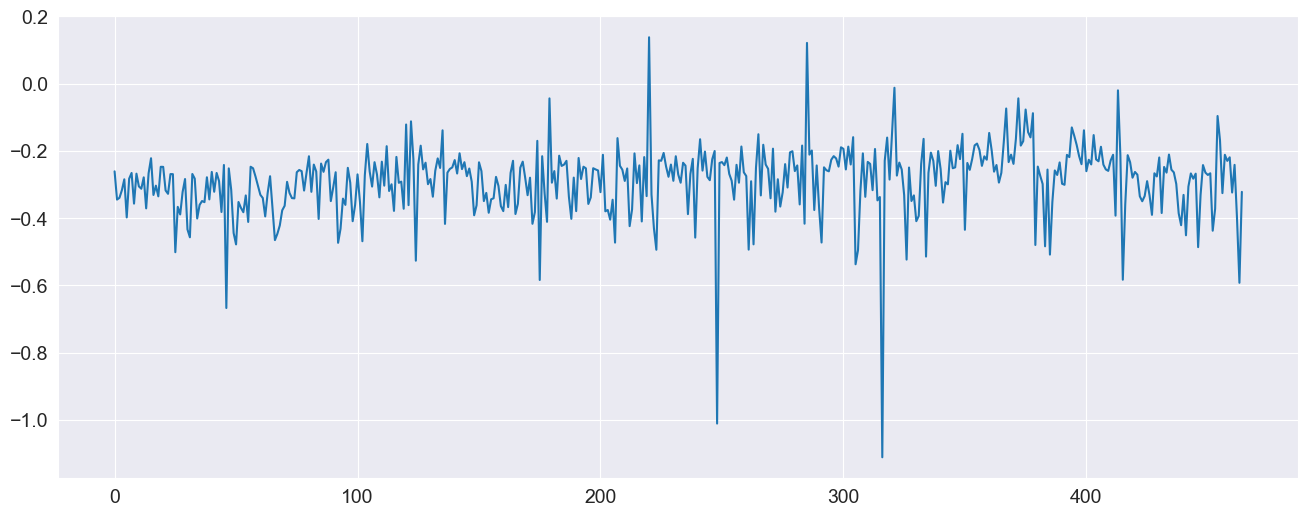

In [3]:
data15.Delta.plot()

<Axes: >

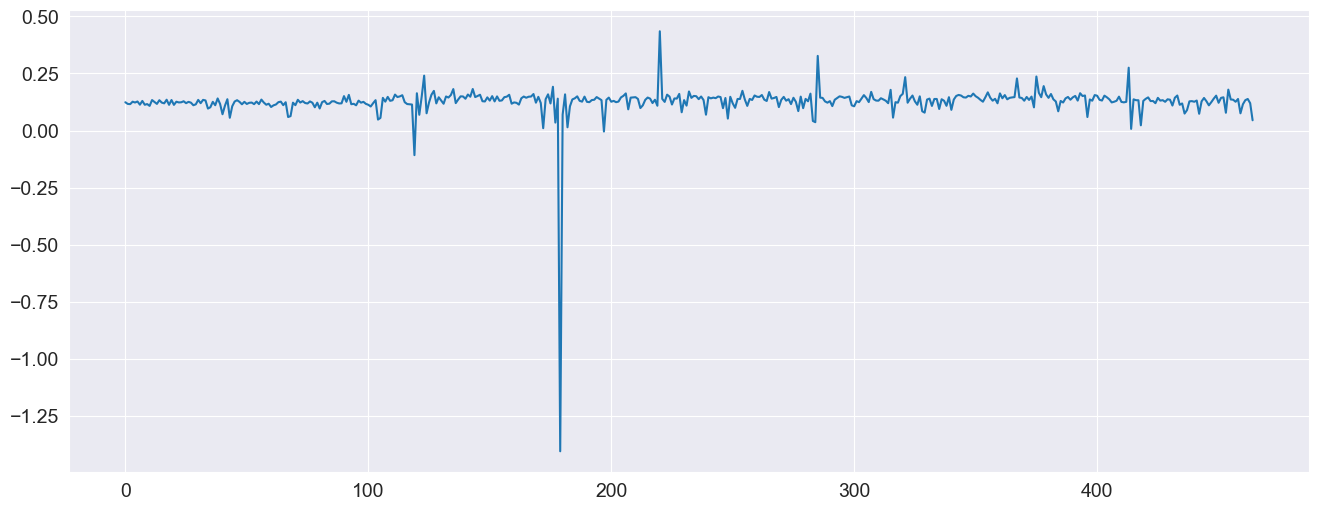

In [4]:
data15.Damkohler.plot()

<Axes: >

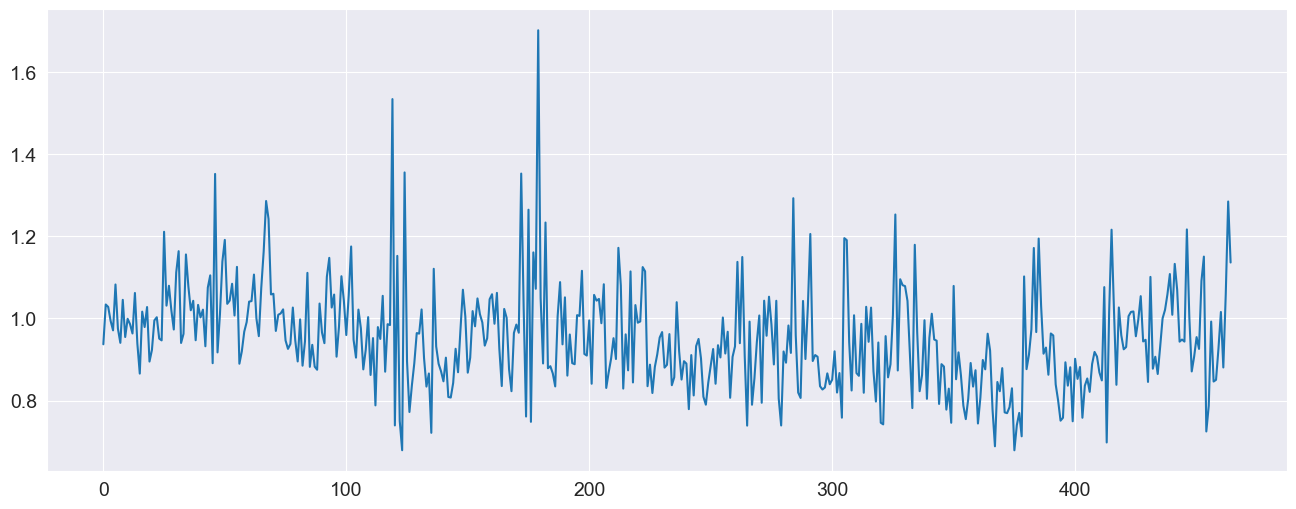

In [5]:
data15.Sigma.plot()

In [12]:
data15 = data15.drop(['Damkohler', 'CUM_Steam'], axis=1)

In [13]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [14]:
data15.head()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 00:00:00,-0.260848,0.937022,108.666275
2023-01-01 00:01:00,-0.344876,1.033851,109.853065
2023-01-01 00:02:00,-0.339656,1.027957,112.921150
2023-01-01 00:03:00,-0.317045,0.993998,112.257874
2023-01-01 00:04:00,-0.284570,0.971008,112.399788


In [15]:
train_size = int(len(data15_comp)*0.9)

data15_train = data15_comp[:train_size]
data15_test = data15_comp[train_size:]

In [16]:
data15_train.tail()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 06:53:00,-0.019786,0.698172,99.826800
2023-01-01 06:54:00,-0.214339,1.014626,95.201584
2023-01-01 06:55:00,-0.583381,1.215810,95.179120
2023-01-01 06:56:00,-0.359145,1.018535,95.548090
2023-01-01 06:57:00,-0.212672,0.838498,95.176450


In [17]:
data15_test.head

<bound method NDFrame.head of                         Delta     Sigma  Woodloading
Time                                                
2023-01-01 06:58:00 -0.233596  1.026638    95.168365
2023-01-01 06:59:00 -0.279739  0.958988    95.179190
2023-01-01 07:00:00 -0.262664  0.924855    93.540530
2023-01-01 07:01:00 -0.270834  0.930323    96.737830
2023-01-01 07:02:00 -0.335122  1.005575    97.097946
2023-01-01 07:03:00 -0.349825  1.015849   119.443611
2023-01-01 07:04:00 -0.334237  1.016895   119.783524
2023-01-01 07:05:00 -0.290098  0.956581   113.750542
2023-01-01 07:06:00 -0.332132  0.996863   115.094070
2023-01-01 07:07:00 -0.390295  1.054142   115.286476
2023-01-01 07:08:00 -0.266612  0.943999   115.359390
2023-01-01 07:09:00 -0.276048  0.947911   100.718018
2023-01-01 07:10:00 -0.219576  0.845482   105.056221
2023-01-01 07:11:00 -0.384826  1.100989   102.277687
2023-01-01 07:12:00 -0.247729  0.877694    98.708435
2023-01-01 07:13:00 -0.264649  0.906773   106.690132
2023-01-01 07:14

### Stationarity

In [18]:
# Delta Stationarity
sts.adfuller(data15_comp.Delta)

(-13.420727312146344,
 4.194921862968695e-25,
 1,
 463,
 {'1%': -3.44455286264131,
  '5%': -2.8678027030003483,
  '10%': -2.5701057817594894},
 -715.5429868985007)

In [19]:
# Sigma Stationarity
sts.adfuller(data15_comp.Sigma)

(-4.9555843182361965,
 2.7152114817910507e-05,
 6,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 -607.1950592220637)

### ACF

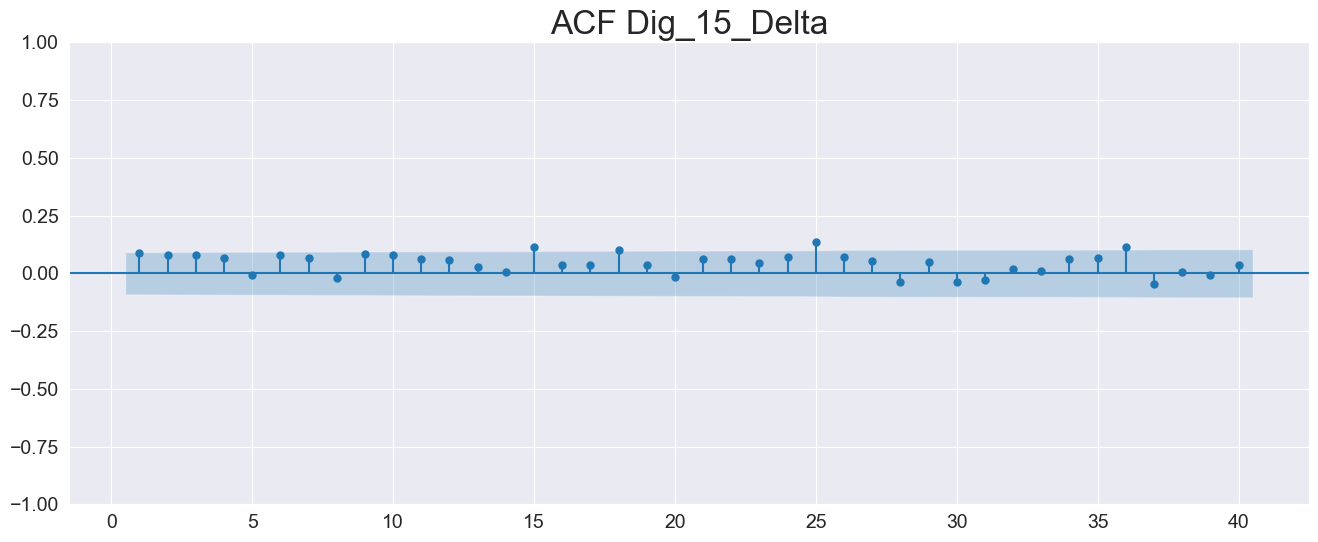

In [20]:
# Delta ACF
sgt.plot_acf(data15.Delta, lags = 40, zero = False)
plt.title("ACF Dig_15_Delta", size = 24)
plt.show()

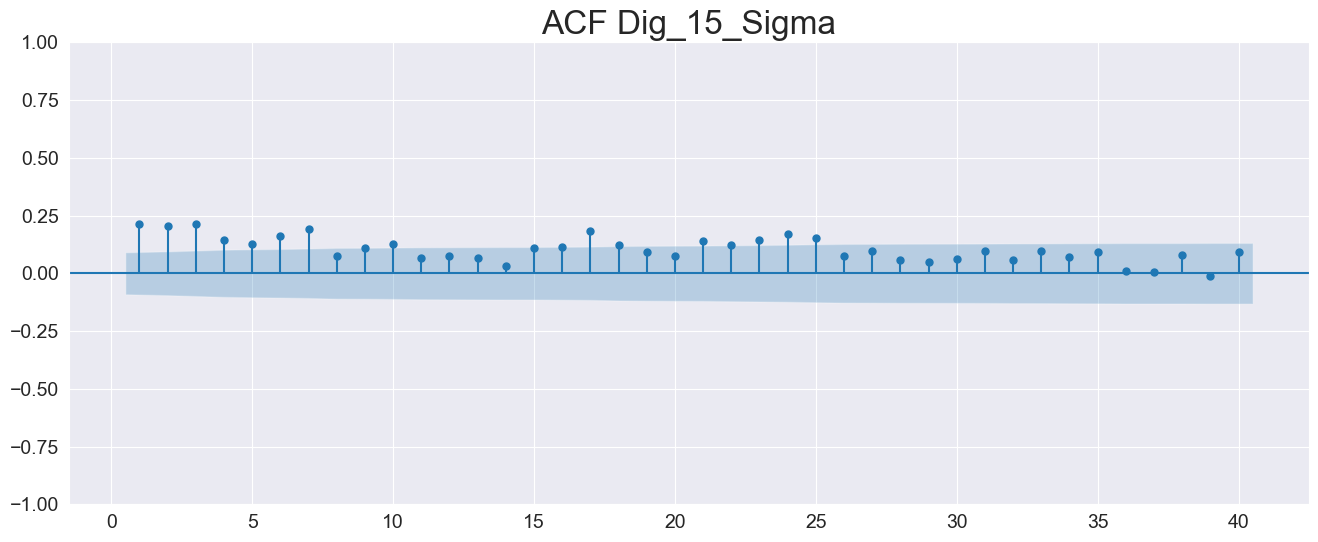

In [21]:
# Sigma ACF
sgt.plot_acf(data15.Sigma, lags = 40, zero = False)
plt.title("ACF Dig_15_Sigma", size = 24)
plt.show()

### PACF

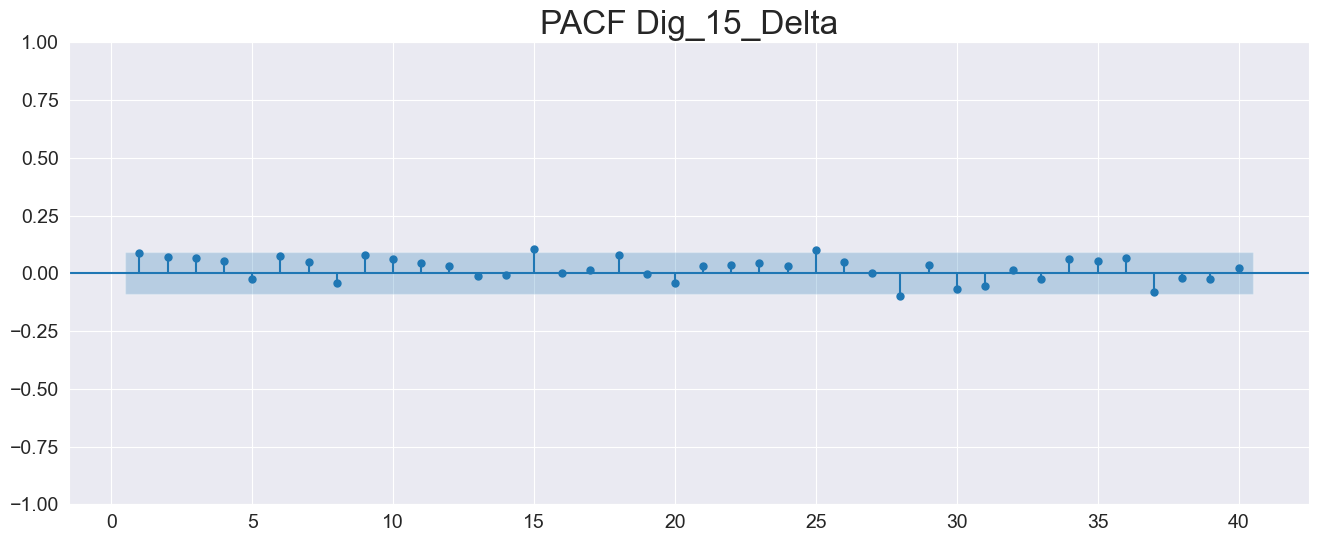

In [22]:
# Delta PACF
sgt.plot_pacf(data15.Delta, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_Delta", size = 24)
plt.show()

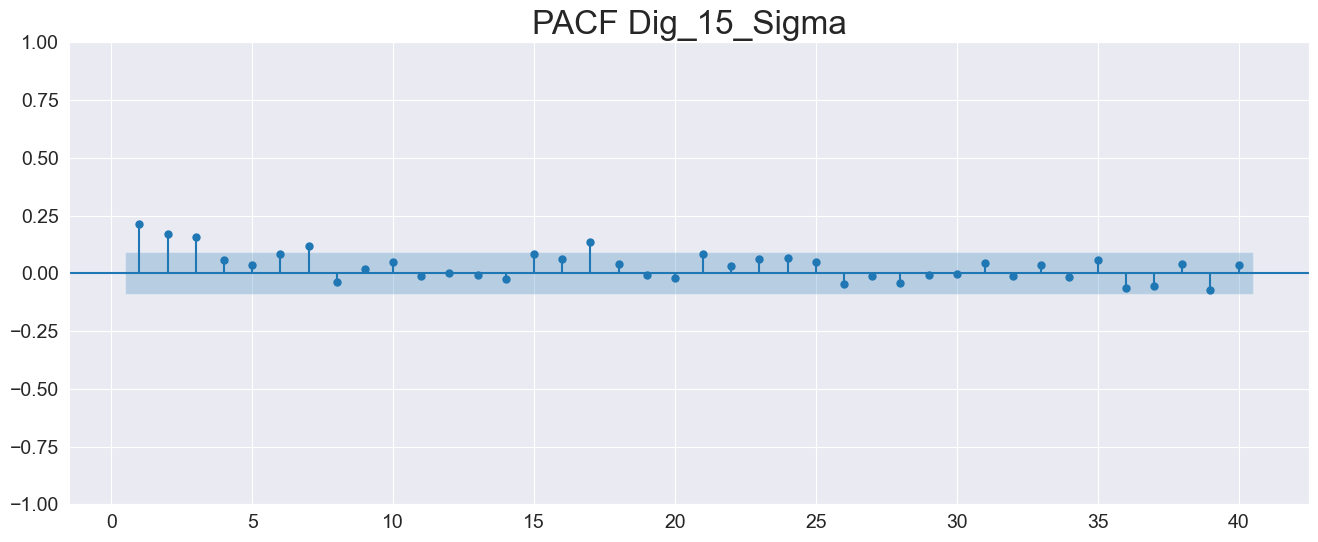

In [24]:
# Sigma PACF
sgt.plot_pacf(data15.Sigma, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_Sigma", size = 24)
plt.show()

In [25]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p